<a href="https://colab.research.google.com/github/gmxavier/FAT0413150/blob/main/notebooks/05.01-Simulating-Block-Diagrams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating block diagrams

>N.B.: Parts of this notebook were taken from [here](https://github.com/alchemyst/Dynamics-and-Control/blob/master/Simulation/Blocksim.ipynb).

## Summary

`tbcontrol.blocksim` is a simple library for simulating block diagrams like this one.

Let's start with this feedback control loop taken from [here](https://sites.chemengr.ucsb.edu/~ceweb/faculty/seborg/teaching/SEM_2_slides/Chapter%2011%20(11-23-04).pdf).


![simple_feedback](http://apmonitor.com/che436/uploads/Main/block_diagram.png)

## Initializations

In [1]:
!pip install tbcontrol
from tbcontrol import blocksim 
import numpy # as we usual need some numerical gadgets
import matplotlib.pyplot as plt # in order to produce nice plots
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Building a block diagram

We need to define objects representing each of the blocks. A common one is the LTI block, so the first block is

In [2]:
Km = blocksim.LTI('Km', 'xsp', 'xsptilde', (20-4)/(1-0))
Km

LTI: xsp →[ Km ]→ xsptilde

The control loop uses a PI controller, so

In [3]:
Gc = blocksim.PI('Gc', 'e', 'p', 5, 5)
Gc

PI: e →[ Gc ]→ p

In order to limit the controller output, we define also a limiter block as following, assuming a controller bias of 12 mA.

In [4]:
def limit(t, u):
    return numpy.clip(u, -4, 4)

Limiter = blocksim.AlgebraicEquation('Limiter', 'p', 'plimited', limit)

And the following blocks are

In [5]:
Kip = blocksim.LTI('Kip', 'plimited', 'pt', (15-3)/(20-12))
Kip

LTI: plimited →[ Kip ]→ pt

In [6]:
Gv = blocksim.LTI('Gv', 'pt', 'w2', (20-0)/(15-3), [1/60, 1])
Gv

LTI: pt →[ Gv ]→ w2

In [7]:
Vrho = 100 # kg
wbar = 10  # kg/min
w1bar = 5  # kg/min
xbar = 0.5 # mass fraction
tau1 = tau2 = Vrho/wbar # min
K1 = w1bar/wbar         # dimensionless
K2 = (1 - xbar)/wbar    # mass fraction/(kg/min)
Gd = blocksim.LTI('Gd', 'x1', 'xd', K1, [tau1, 1])
Gd

LTI: x1 →[ Gd ]→ xd

In [8]:
Gp = blocksim.LTI('Gp', 'w2', 'xu', K2, [tau2, 1])
Gp

LTI: w2 →[ Gp ]→ xu

In [9]:
Gm = blocksim.LTI('Gm', 'x', 'xm', (20-4)/(1-0))
Gm

LTI: x →[ Gm ]→ xm

Once we have the blocks, we can create a `Diagram`.

Sums are specified as a dictionary with the keys being the output signal and the values being a tuple containing the input signals. The leading + is compulsory.

The inputs come next and are specified as functions of time. `blocksim.step()` can be used to build a step function.

In [10]:
diagram = blocksim.Diagram([Km, Gc, Limiter, Kip, Gv, Gp, Gd, Gm], 
                           sums={'e': ('+xsptilde', '-xm'),
                                 'x': ('+xd', '+xu')}, 
                           inputs={'xsp': blocksim.step(size=0.1),
                                   'x1' : blocksim.step(starttime=60,size=0.1)})
diagram

LTI: xsp →[ Km ]→ xsptilde
PI: e →[ Gc ]→ p
AlgebraicEquation: p →[ Limiter ]→ plimited
LTI: plimited →[ Kip ]→ pt
LTI: pt →[ Gv ]→ w2
LTI: w2 →[ Gp ]→ xu
LTI: x1 →[ Gd ]→ xd
LTI: x →[ Gm ]→ xm

In the chunk of code above we specify an step change in the setpoint $x_{sp}$ at t = 0 min and a step change in the disturbance $x_1$ at t = 60 min. Both step changes have an amplitude of 0.1 mass fraction. 

`blocksim` is primarily focused on being able to simulate a diagram. The next step is to create a time vector and do the simulation.

The time vector also specifies the step size for integration. Since `blocksim` uses Euler integration internally you should choose a time step which is at least 10 times smaller than the smallest time constant of all the blocks. The timespan is of course dependent on what you are investigating.

In [11]:
ts = numpy.linspace(start=0, stop=120, num=120*100)

In [12]:
simulation_results = diagram.simulate(ts, progress=True)

  0%|          | 0/12000 [00:00<?, ?it/s]

The result of `simulate()` is a dictionary containing the simulation results.

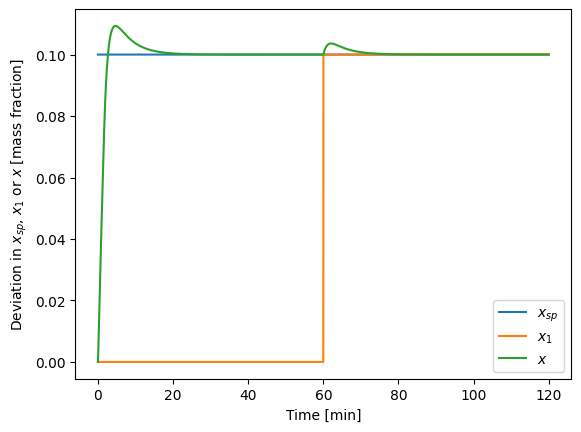

In [13]:
plt.plot(ts, simulation_results['xsp'], ts, simulation_results['x1'], ts, simulation_results['x'])
plt.xlabel('Time [min]')
plt.ylabel('Deviation in $x_{sp}$, $x_1$ or $x$ [mass fraction]')
plt.legend(['$x_{sp}$', '$x_1$', '$x$'])

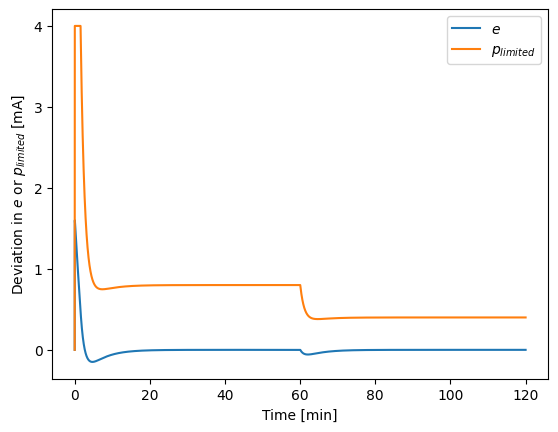

In [14]:
plt.plot(ts, simulation_results['e'], ts, simulation_results['plimited'])
plt.xlabel('Time [min]')
plt.ylabel('Deviation in $e$ or $p_{limited}$ [mA]')
plt.legend(['$e$', '$p_{limited}$'])

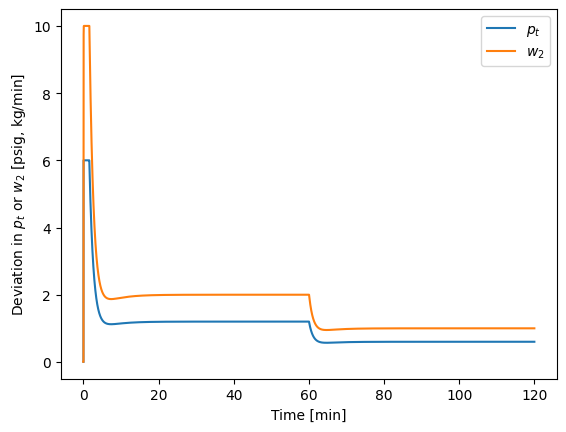

In [15]:
plt.plot(ts, simulation_results['pt'], ts, simulation_results['w2'])
plt.xlabel('Time [min]')
plt.ylabel('Deviation in $p_t$ or $w_2$ [psig, kg/min]')
plt.legend(['$p_t$', '$w_2$'])

Now let's try to simulate the control loop shown [here (Fig. 8-17)](https://udghoshna.files.wordpress.com/2013/06/136649035-process-systems-analysis-and-control-d-coughanowr-3rd-ed.pdf#page=202) 

In [16]:
Kc = 20
Kc = blocksim.LTI('Kc', 'Error', 'Q', Kc)
Kc

LTI: Error →[ Kc ]→ Q

In [17]:
A = 0.0714
A = blocksim.LTI('A', 'Q', 'out1', A)
A

LTI: Q →[ A ]→ out1

In [18]:
tau = 5
Tank = blocksim.LTI('Tank', 'out2', 'T', 1, [tau, 1])
Tank

LTI: out2 →[ Tank ]→ T

In [19]:
taum = 0.33
Thermocouple = blocksim.LTI('Thermocouple', 'T', 'Tm', 1, [taum, 1])
Thermocouple

LTI: T →[ Thermocouple ]→ Tm

In [20]:
diagram = blocksim.Diagram([Kc, A, Tank, Thermocouple], 
                           sums={'Error': ('+Tr', '-Tm'),
                                 'out2': ('+out1', '+Ti')}, 
                           inputs={'Tr': blocksim.step(size=5),
                                   'Ti' : blocksim.step(starttime=15,size=5)})
diagram

LTI: Error →[ Kc ]→ Q
LTI: Q →[ A ]→ out1
LTI: out2 →[ Tank ]→ T
LTI: T →[ Thermocouple ]→ Tm

In [21]:
ts = numpy.linspace(start=0, stop=15, num=15*100)

In [22]:
simulation_results = diagram.simulate(ts, progress=True)

  0%|          | 0/1500 [00:00<?, ?it/s]

With these `simulation_results` we can plot part of the graph shown [here (Fig. 8-18)](https://udghoshna.files.wordpress.com/2013/06/136649035-process-systems-analysis-and-control-d-coughanowr-3rd-ed.pdf#page=202).

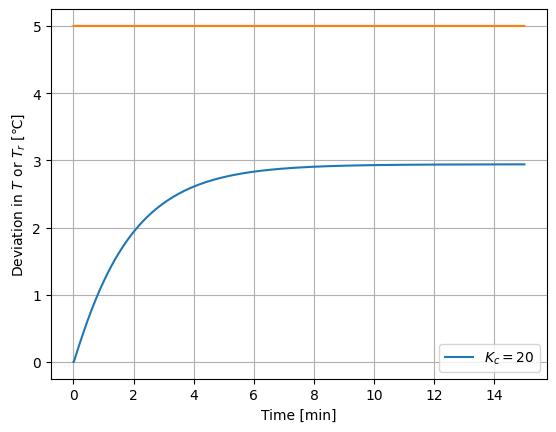

In [23]:
plt.plot(ts, simulation_results['T'], ts, simulation_results['Tr'])
plt.xlabel('Time [min]')
plt.ylabel('Deviation in $T$ or $T_r$ [℃]')
plt.legend(['$K_c = 20$'])
plt.grid()

Now we can add all chunks of code together and plot exactly the same graph shown [here (Fig. 12-5)](https://udghoshna.files.wordpress.com/2013/06/136649035-process-systems-analysis-and-control-d-coughanowr-3rd-ed.pdf#page=254).   

Remember that the change amplitude in the setpoint $T_r$ was 5℃, so this graph shows how the offset decreases with the increasing of $K_c$.

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

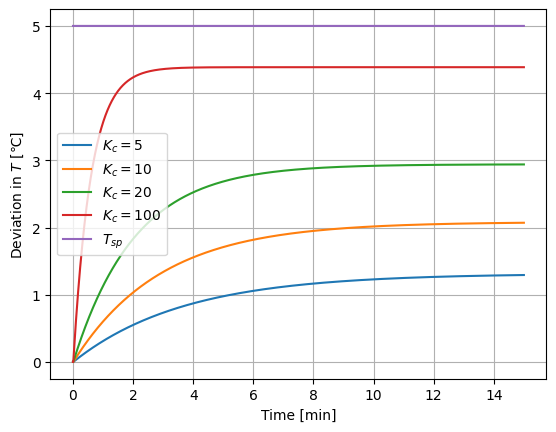

In [24]:
ts = numpy.linspace(start=0, stop=15, num=15*100)
def ex81(ts=ts, Kc=100, tau=5, taum=0, A = 0.0714, sizes=[5,5], starttimes=[0,15]):
  Kc = blocksim.LTI('Kc', 'Error', 'Q', Kc)
  A = blocksim.LTI('A', 'Q', 'out1', A)
  Tank = blocksim.LTI('Tank', 'out2', 'T', 1, [tau, 1])
  Thermocouple = blocksim.LTI('Thermocouple', 'T', 'Tm', 1, [taum, 1])
  diagram = blocksim.Diagram([Kc, A, Tank, Thermocouple], 
                           sums={'Error': ('+Tr', '-Tm'),
                                 'out2': ('+out1', '+Ti')}, 
                           inputs={'Tr': blocksim.step(size=sizes[0]),
                                   'Ti' : blocksim.step(starttime=starttimes[1],size=sizes[1])})
  return diagram.simulate(ts, progress=True)

Kcs = [5, 10, 20, 100]
for Kc in Kcs:
  simulation_results = ex81(Kc=Kc)
  plt.plot(ts, simulation_results['T'])
  plt.xlabel('Time [min]')
  plt.ylabel('Deviation in $T$ [℃]')

plt.plot(ts, 5+0*ts)
plt.legend(['$K_c = {0}$'.format(Kc) for Kc in Kcs]+['$T_{sp}$'])
plt.grid()

Now let's try to simulate the control loop shown [here (Example 5.7)](https://ia802909.us.archive.org/32/items/process-control-a-first-course-with-matlab/Process%20Control%20A%20First%20Course%20with%20MATLAB.pdf#page=117) 

In [25]:
Km = blocksim.LTI('Km', 'R', 'Rtilde', 2.6) # Km = 2.6 mv/ppm
Km

LTI: R →[ Km ]→ Rtilde

In [26]:
Gc = blocksim.PID('Gc', 'E', 'P', 2.8, 3.1, 0.31) # Taken from Example 5.7A, p. 112
Gc

PID: E →[ Gc ]→ P

In [27]:
Ga = blocksim.LTI('Ga', 'P', 'M', 0.6, [0.2, 1]) # Ka = 0.2 mL/s/mV, taua = 0.2 sec
Ga

LTI: P →[ Ga ]→ M

In [28]:
Gp = blocksim.LTI('Gp', 'M', 'C', 0.8, [20./5., 1]) # Kp = 0.8 ppm/mL/s, taup = 20./5. s
Gp

LTI: M →[ Gp ]→ C

In [29]:
# We will split Gm in two blocks, one for the transport delay
Delay = blocksim.Deadtime('Delay', 'C', 'Cd', 290./400.) # L = 290 cm, A = 5 cm2, Q = 2000 cm3/s
                                                         # avg. fluid velocity = 2000 cm3/s / 5 cm2 = 
                                                         # 400 cm/s, td = 290 cm / 400 cm/s
Delay

Deadtime: C →[ Delay ]→ Cd

In [30]:
# And other for the steady-state gain
Gm = blocksim.LTI('Gm', 'Cd', 'Cm', 2.6) # Km = 2.6 mv/ppm
Gm

LTI: Cd →[ Gm ]→ Cm

In [31]:
diagram = blocksim.Diagram([Km, Gc, Ga, Gp, Delay, Gm], 
                           sums={'E': ('+Rtilde', '-Cm')}, 
                           inputs={'R': blocksim.step(size=1.)})
diagram

LTI: R →[ Km ]→ Rtilde
PID: E →[ Gc ]→ P
LTI: P →[ Ga ]→ M
LTI: M →[ Gp ]→ C
Deadtime: C →[ Delay ]→ Cd
LTI: Cd →[ Gm ]→ Cm

In [32]:
ts = numpy.linspace(start=0, stop=50, num=50*100)

In [34]:
simulation_results = diagram.simulate(ts, progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

With these `simulation_results` we can plot the closed-loop response.

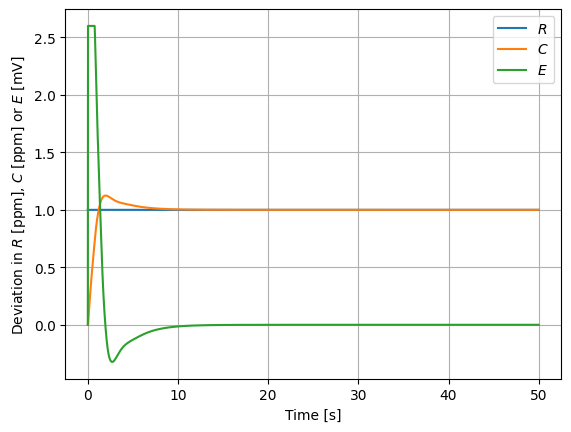

In [35]:
plt.plot(ts, simulation_results['R'], ts, simulation_results['C'], ts, simulation_results['E'])
plt.xlabel('Time [s]')
plt.ylabel('Deviation in $R$ [ppm], $C$ [ppm] or $E$ [mV]')
plt.legend(['$R$', '$C$', '$E$'])
plt.grid()

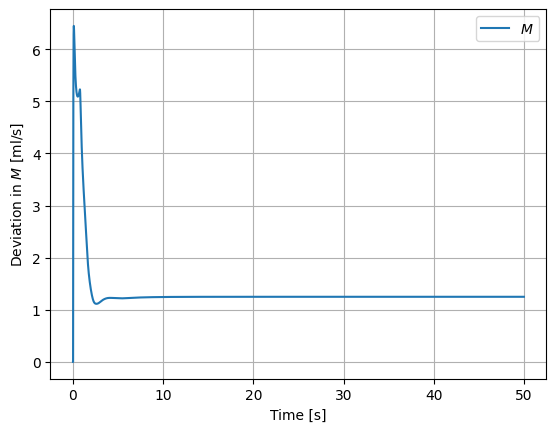

In [36]:
plt.plot(ts, simulation_results['M'])
plt.xlabel('Time [s]')
plt.ylabel('Deviation in $M$ [ml/s]')
plt.legend(['$M$'])
plt.grid()

Now we can add all chunks of code together and plot a graph showing the closed-loop responses for some tuning rules.

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

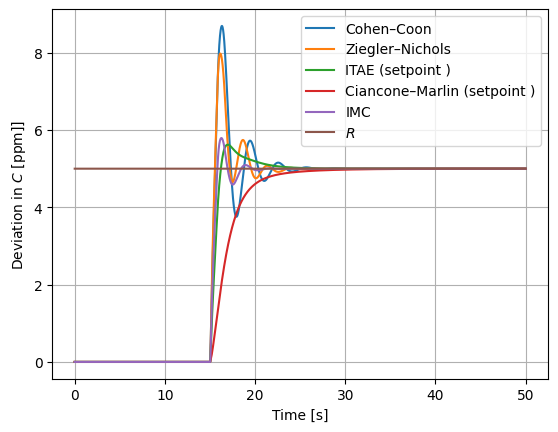

In [37]:
ts = numpy.linspace(start=0, stop=50, num=50*100)
def ex57(ts=ts, Kc=1, tau_i=1, tau_d=1, sizes=[5,0], starttimes=[15,0]):
  Km = blocksim.LTI('Km', 'R', 'Rtilde', 2.6) # Km = 2.6 mv/ppm
  Gc = blocksim.PID('Gc', 'E', 'P', Kc, tau_i, tau_d)
  Ga = blocksim.LTI('Ga', 'P', 'M', 0.6, [0.2, 1]) # Ka = 0.2 mL/s/mV, taua = 0.2 sec
  Gp = blocksim.LTI('Gp', 'M', 'C', 0.8, [20./5., 1]) # Kp = 0.8 ppm/mL/s, taup = 20./5. s
  Delay = blocksim.Deadtime('Delay', 'C', 'Cd', 290./400.)
  Gm = blocksim.LTI('Gm', 'Cd', 'Cm', 2.6) # Km = 2.6 mv/ppm
  diagram = blocksim.Diagram([Km, Gc, Ga, Gp, Delay, Gm], 
                             sums={'E': ('+Rtilde', '-Cm')}, 
                             inputs={'R': blocksim.step(size=sizes[0],starttime=starttimes[0])})
  return diagram.simulate(ts, progress=True)

Kcs = [4.9, 4.3, 2.8, 1.2, 3.4]
tau_is = [2.0, 1.8, 3.1, 4.4, 4.5]
tau_ds = [0.31, 0.45, 0.31, 0.07, 0.4]
rules = ['Cohen–Coon', 'Ziegler–Nichols', 'ITAE (setpoint )', 'Ciancone–Marlin (setpoint )', 'IMC']

for k, rule in enumerate(rules):
  simulation_results = ex57(Kc=Kcs[k], tau_i= tau_is[k], tau_d = tau_ds[k])
  plt.plot(ts, simulation_results['C'])
  plt.xlabel('Time [s]')
  plt.ylabel('Deviation in $C$ [ppm]')

plt.plot(ts, 5+0*ts)
plt.legend(['{0}'.format(rule) for rule in rules]+['$R$'])
plt.grid()

As it was expected, the Cohen-Coon and Zigler-Nichols tuning rules shown the worst performance (actually they were developed for regulatory not servo control).

The ITAE (setpoint) tuning rule shown a good performance, but the IMC tuning rule was superior. The Ciancone-Marlin (stepoint) provided the slowest response and is the most conservative one.

We can also simulate the process reaction curve using the code bellow.

  0%|          | 0/5000 [00:00<?, ?it/s]

Text(0, 0.5, '$C$ [ppm]')

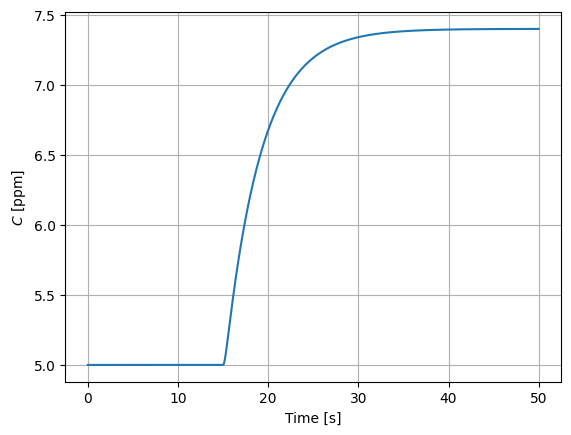

In [48]:
ts = numpy.linspace(start=0, stop=50, num=50*100)
def ex57ol(ts=ts, sizes=[5,0], starttimes=[15,0]):
  Ga = blocksim.LTI('Ga', 'P', 'M', 0.6, [0.2, 1]) # Ka = 0.2 mL/s/mV, taua = 0.2 sec
  Gp = blocksim.LTI('Gp', 'M', 'C', 0.8, [20./5., 1]) # Kp = 0.8 ppm/mL/s, taup = 20./5. s
  Delay = blocksim.Deadtime('Delay', 'C', 'Cd', 290./400.)
  Gm = blocksim.LTI('Gm', 'Cd', 'Cm', 2.6) # Km = 2.6 mv/ppm
  diagram = blocksim.Diagram([Ga, Gp, Delay, Gm], 
                             sums = {},
                             inputs={'P': blocksim.step(size=sizes[0],starttime=starttimes[0])})
  return diagram.simulate(ts, progress=True)

simulation_results = ex57ol()
y = [x+5 for x in simulation_results['C']]
plt.plot(ts, y)
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('$C$ [ppm]')

In [46]:
simulation_results['C']

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0